In [ ]:
!pip install timm --quiet

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 📚 Import dependencies
import os
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import timm

# ⚙️ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Paths (adjust folder names if needed)
train_csv_path = '/content/drive/MyDrive/ML 2/Image capstioning/_Train.csv'
test_csv_path = '/content/drive/MyDrive/ML 2/Image capstioning/_Test.csv'
valid_csv_path = '/content/drive/MyDrive/ML 2/Image capstioning/_Validation.csv'

train_zip_path = '/content/drive/MyDrive/ML 2/Image capstioning/train.zip'
test_zip_path = '/content/drive/MyDrive/ML 2/Image capstioning/test.zip'
valid_zip_path = '/content/drive/MyDrive/ML 2/Image capstioning/valid.zip'

In [ ]:
# Extract training images
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ML 2/Image capstioning/train')

KeyboardInterrupt: 

In [ ]:
# Extract testing images
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ML 2/Image capstioning/test')

In [ ]:
with zipfile.ZipFile(valid_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ML 2/Image capstioning/valid')

In [ ]:
# Load CSVs
train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)
test_df = pd.read_csv(test_csv_path)

# Get label column (only one is 1 per row)
label_cols = train_df.columns[1:]
train_df['label'] = train_df[label_cols].idxmax(axis=1)
valid_df['label'] = valid_df[label_cols].idxmax(axis=1)
test_df['label'] = test_df[label_cols].idxmax(axis=1)

# Encode classes
label_encoder = LabelEncoder()
train_df['label_idx'] = label_encoder.fit_transform(train_df['label'])
valid_df['label_idx'] = label_encoder.transform(valid_df['label'])  # same encoder
test_df['label_idx'] = label_encoder.transform(test_df['label'])  # same encoder

# Optional: print class names
print("Class names:", label_encoder.classes_)

Class names: [' Renaissance' ' Surrealism' ' Unlabeled' ' baroque' ' cubism'
 ' minimalist' ' popart' ' realism' ' renaissance' ' romanticism']


In [ ]:
class ArtDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.dataframe.loc[idx, 'filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.loc[idx, 'label_idx']

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# ImageNet normalization stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ArtDataset(train_df, image_dir="/content/drive/MyDrive/ML 2/Image capstioning/train/train", transform=train_transform)
valid_dataset = ArtDataset(valid_df, image_dir="/content/drive/MyDrive/ML 2/Image capstioning/valid/valid", transform=test_transform)
test_dataset = ArtDataset(test_df, image_dir="/content/drive/MyDrive/ML 2/Image capstioning/test/test", transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
def get_efficientnet_model(num_classes):
    model = timm.create_model('efficientnet_b0', pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model.to(device)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CNNWithSE(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithSE, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            SEBlock(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            SEBlock(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            SEBlock(128)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Example instantiation
# model = CNNWithSE(num_classes=11).to(device)

In [ ]:
def train_one_epoch(model, optimizer, criterion, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
def run_training(model, train_loader, valid_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': [],
               'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader)
        val_loss, val_acc = evaluate(model, criterion, valid_loader)
        test_loss, test_acc = evaluate(model, criterion, test_loader)

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        print(f"Test  Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("✅ Best model saved.")

    return history

In [ ]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.plot(epochs, history['test_loss'], label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.plot(epochs, history['test_acc'], label='Test Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
print(train_df['filename'].iloc[0])

baroque-style-painting96_jpg.rf.1997afc46b505f00f34af832c3442455.jpg



Epoch 1/10


Train Loss: 1.3503 | Acc: 0.5855
Val   Loss: 0.9500 | Acc: 0.6703
Test  Loss: 0.8792 | Acc: 0.6996
✅ Best model saved.

Epoch 2/10


Train Loss: 0.6258 | Acc: 0.7904
Val   Loss: 0.9371 | Acc: 0.6832
Test  Loss: 0.7856 | Acc: 0.7210
✅ Best model saved.

Epoch 3/10


Train Loss: 0.3313 | Acc: 0.8959
Val   Loss: 0.9935 | Acc: 0.6897
Test  Loss: 0.8525 | Acc: 0.7167
✅ Best model saved.

Epoch 4/10


Train Loss: 0.1760 | Acc: 0.9492
Val   Loss: 1.1081 | Acc: 0.6875
Test  Loss: 0.9979 | Acc: 0.6953

Epoch 5/10


Train Loss: 0.1150 | Acc: 0.9641
Val   Loss: 1.2707 | Acc: 0.6875
Test  Loss: 1.1626 | Acc: 0.6910

Epoch 6/10


Train Loss: 0.0903 | Acc: 0.9701
Val   Loss: 1.3004 | Acc: 0.6746
Test  Loss: 1.1986 | Acc: 0.6910

Epoch 7/10


Train Loss: 0.0750 | Acc: 0.9727
Val   Loss: 1.3887 | Acc: 0.6940
Test  Loss: 1.2373 | Acc: 0.6867
✅ Best model saved.

Epoch 8/10


Train Loss: 0.0683 | Acc: 0.9748
Val   Loss: 1.3888 | Acc: 0.6940
Test  Loss: 1.3316 | Acc: 0.6781

Epoch 9/10


Train Loss: 0.0684 | Acc: 0.9762
Val   Loss: 1.4981 | Acc: 0.6918
Test  Loss: 1.3937 | Acc: 0.7124

Epoch 10/10


Train Loss: 0.0594 | Acc: 0.9791
Val   Loss: 1.5395 | Acc: 0.6918
Test  Loss: 1.4633 | Acc: 0.6738


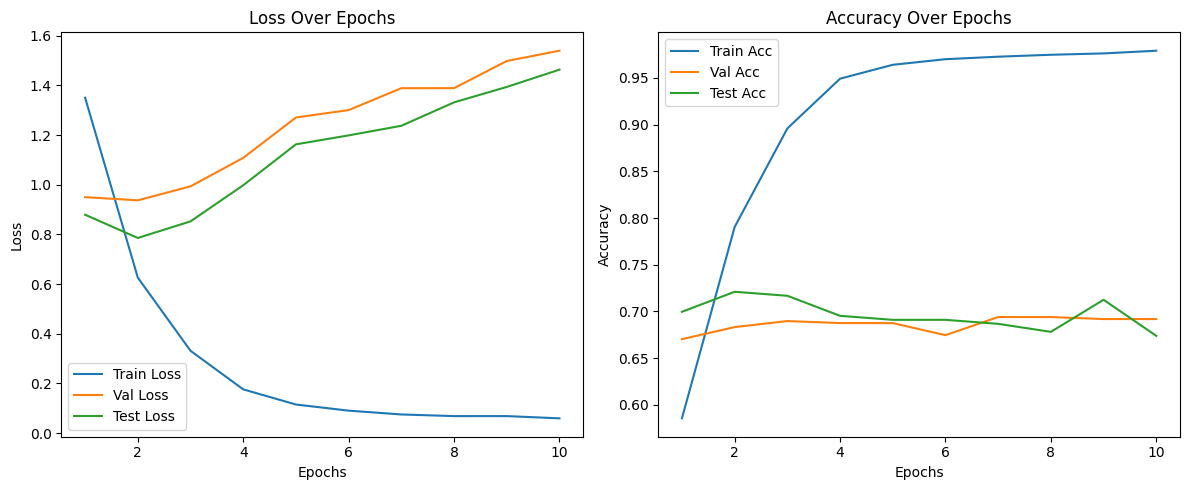

In [ ]:
num_classes = len(label_encoder.classes_)
model_0 = get_efficientnet_model(num_classes)
history = run_training(model_0, train_loader, valid_loader, test_loader, num_epochs=10)
plot_training_curves(history)


Epoch 1/10


Train Loss: 1.8859 | Acc: 0.3063
Val   Loss: 1.6432 | Acc: 0.3944
Test  Loss: 1.6875 | Acc: 0.3863
✅ Best model saved.

Epoch 2/10


Train Loss: 1.7003 | Acc: 0.3746
Val   Loss: 1.5506 | Acc: 0.4246
Test  Loss: 1.6115 | Acc: 0.4077
✅ Best model saved.

Epoch 3/10


Train Loss: 1.6289 | Acc: 0.4067
Val   Loss: 1.5408 | Acc: 0.4224
Test  Loss: 1.6011 | Acc: 0.3906

Epoch 4/10


Train Loss: 1.5791 | Acc: 0.4331
Val   Loss: 1.5026 | Acc: 0.4332
Test  Loss: 1.5849 | Acc: 0.4464
✅ Best model saved.

Epoch 5/10


Train Loss: 1.5400 | Acc: 0.4416
Val   Loss: 1.4701 | Acc: 0.4267
Test  Loss: 1.5325 | Acc: 0.4506

Epoch 6/10


Train Loss: 1.5068 | Acc: 0.4595
Val   Loss: 1.4549 | Acc: 0.4375
Test  Loss: 1.4936 | Acc: 0.5064
✅ Best model saved.

Epoch 7/10


Train Loss: 1.4595 | Acc: 0.4713
Val   Loss: 1.4666 | Acc: 0.4375
Test  Loss: 1.5417 | Acc: 0.4549

Epoch 8/10


Train Loss: 1.4288 | Acc: 0.4880
Val   Loss: 1.4472 | Acc: 0.4591
Test  Loss: 1.4672 | Acc: 0.5193
✅ Best model saved.

Epoch 9/10


Train Loss: 1.4022 | Acc: 0.4965
Val   Loss: 1.4586 | Acc: 0.4418
Test  Loss: 1.4823 | Acc: 0.4936

Epoch 10/10


Train Loss: 1.3649 | Acc: 0.5074
Val   Loss: 1.4346 | Acc: 0.4526
Test  Loss: 1.4660 | Acc: 0.5150


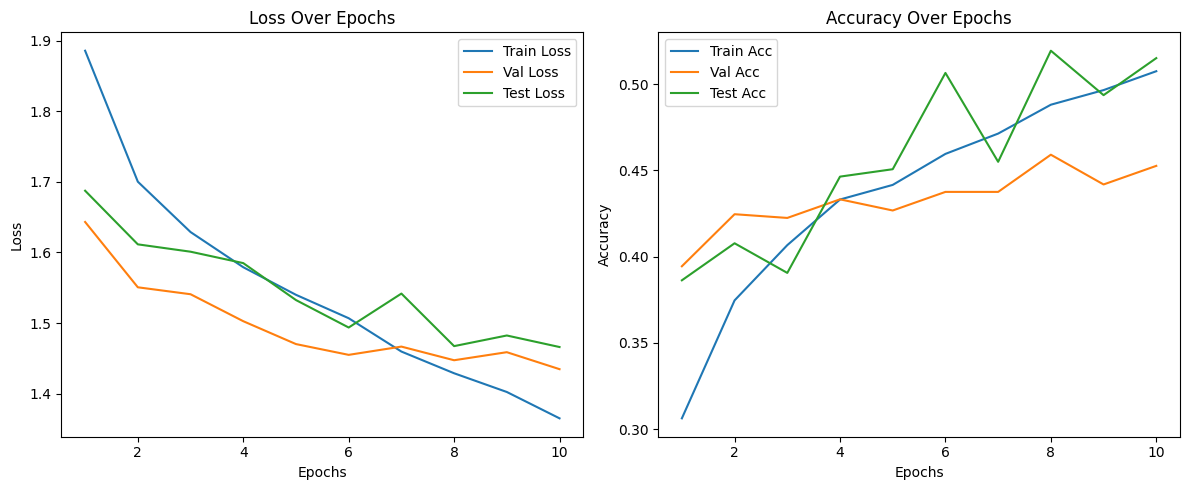

In [ ]:
model = CNNWithSE(num_classes).to(device)
history = run_training(model, train_loader, valid_loader, test_loader, num_epochs=10)
plot_training_curves(history)

In [ ]:
# Get the most frequent class index in train set
majority_class_idx = train_df['label_idx'].value_counts().idxmax()

# For reference (optional)
majority_class_name = label_encoder.inverse_transform([majority_class_idx])[0]
print(f"Most frequent class: {majority_class_name} (index {majority_class_idx})")

Most frequent class:  cubism (index 4)


In [ ]:
import torch.nn as nn

class NaiveMajorityModel(nn.Module):
    def __init__(self, majority_class_idx, num_classes):
        super(NaiveMajorityModel, self).__init__()
        self.majority_class_idx = majority_class_idx
        self.num_classes = num_classes

    def forward(self, x):
        # Batch size
        batch_size = x.size(0)
        output = torch.zeros(batch_size, self.num_classes).to(x.device)
        output[:, self.majority_class_idx] = 1.0  # confidence = 1.0 for majority class
        return output

# Instantiate model
model = NaiveMajorityModel(majority_class_idx, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, criterion, test_loader)

print(f"\n Naive Majority Model Accuracy: {test_acc:.4f}")
print(f" Naive Majority Model Loss: {test_loss:.4f}")


 Naive Majority Model Accuracy: 0.1373
 Naive Majority Model Loss: 2.3238
